In [178]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
% matplotlib inline
import seaborn as sns
from nltools.data import Adjacency
from scipy import stats
# Package functions
from multivariate_inference.helpers import upper, isPSD, nearestPSD, easy_multivariate_normal, create_heterogeneous_simulation, kde_pvalue

SAS blog about correlation matrices and PSD:  
https://blogs.sas.com/content/iml/2012/09/12/when-is-a-correlation-matrix-not-a-correlation-matrix.html

In [115]:
def abline(slope, intercept):
    """Plot a line from slope and intercept"""
    axes = plt.gca()
    x_vals = np.array(axes.get_xlim())
    y_vals = intercept + slope * x_vals
    plt.plot(x_vals, y_vals, '--')

## KDE Perm vs Empirical Perm

In [331]:
def kde_vs_empirical_sim(nsim,true_r,nperm,tails,lower_r=-1,upper_r=1,dist_type='uniform',dist_args=None,seed=None,plot=True):
    """
    Compare kde permutation vs empirical permutation via simulation of a permuted distribution.
    
    Args:
        nsim: number of simulations
        true_r: stat value to get a p-value for
        lower_r: lower bound of permuted distribution
        upper_r: upper bound of permuted distribution
        nperm: size of the permutation distribution
        tails: one or two tailed p-value
        dist_type: what shape should the permutation distribution have ('uniform','skew','trunc_normal'); optionally pass custom function to generate permuted values
    
    Returns:
        permutation distribution
        empirical pvalues
        kde pvalues
        p-val lookup func for kde
    """
    
    if seed:
        np.random.seed(seed)
        
    kde_ps,empirical_ps = [],[]
    for i in range(nsim):
        
        if dist_type == 'uniform':
            perms = np.random.uniform(lower_r,upper_r,nperm)
        elif dist_type == 'skew':
            if dist_args is None:
                raise ValueError("With skewed distribution, dist_args skew parameter must be set")
            perms = stats.skewnorm(dist_args).rvs(nperm)
            perms = np.clip(perms,lower_r,upper_r)
        elif dist_type == 'trunc_normal':
            if dist_args is not None and len(dist_args) == 2:
                perms = stats.truncnorm(lower_r,upper_r,loc=dist_args[0],scale=dist_args[1]).rvs(nperm)
            else:
                perms = stats.truncnorm(lower_r,upper_r).rvs(nperm)
        elif callable(dist_type):
            perms = dist_type(nperm)
        else:
            raise ValueError("dist_type must be one of 'uniform','skew','trunc_normal', or a custom function")
        
        # KDE p-value
        p, pfunc = kde_pvalue(perms, true_r, tails=tails)
        kde_ps.append(p)
        
        # Empirical p-value
        if true_r > 0:
            left = np.sum(perms >= true_r) / nperm
            right = np.sum(perms <= -1*true_r) / nperm
        else:
            left = np.sum(perms <= true_r) / nperm
            right = np.sum(perms >= -1*true_r) / nperm
        
        if tails == 2:
            empirical_ps.append(left + right)
        elif tails == 1:
            empirical_ps.append(left)
        
    if plot:
        min_lim = np.max([np.min(np.hstack([empirical_ps,kde_ps])) - .01,0])
        max_lim = np.min([np.max(np.hstack([empirical_ps,kde_ps])) + .01,1])
        bw = (np.median(np.abs(perms - np.median(perms))) / 0.6745) * (4 / (3 * len(perms)))** (1 / 5)
        f,ax=plt.subplots(1,2,figsize=(16,5));
        ax[0] = sns.distplot(perms,kde_kws={"gridsize":200,"bw":bw},ax=ax[0]);
        ax[0].axvline(true_r,ax[0].get_ylim()[0],ax[0].get_ylim()[1],ls='--',c='k');
        if callable(dist_type):
            ax[0].set(title=f'Permutation Distribution (type = custom)');
        else:
            ax[0].set(title=f'Permutation Distribution (type = {dist_type})');
        ax[1].scatter(empirical_ps,kde_ps);
        ax[1].set(xlabel='Empirical P-vals',ylabel='KDE P-vals',
               xlim=(min_lim,max_lim),ylim=(min_lim,max_lim),
               title=f'True R = {true_r} Tails = {tails}\nPerm Dist Bounds = [{perms.min()}, {perms.max()}]');
        ax[1].plot(ax[1].get_xlim(),ax[1].get_ylim(),ls='--',c='k')

    return perms, kde_ps, empirical_ps, pfunc

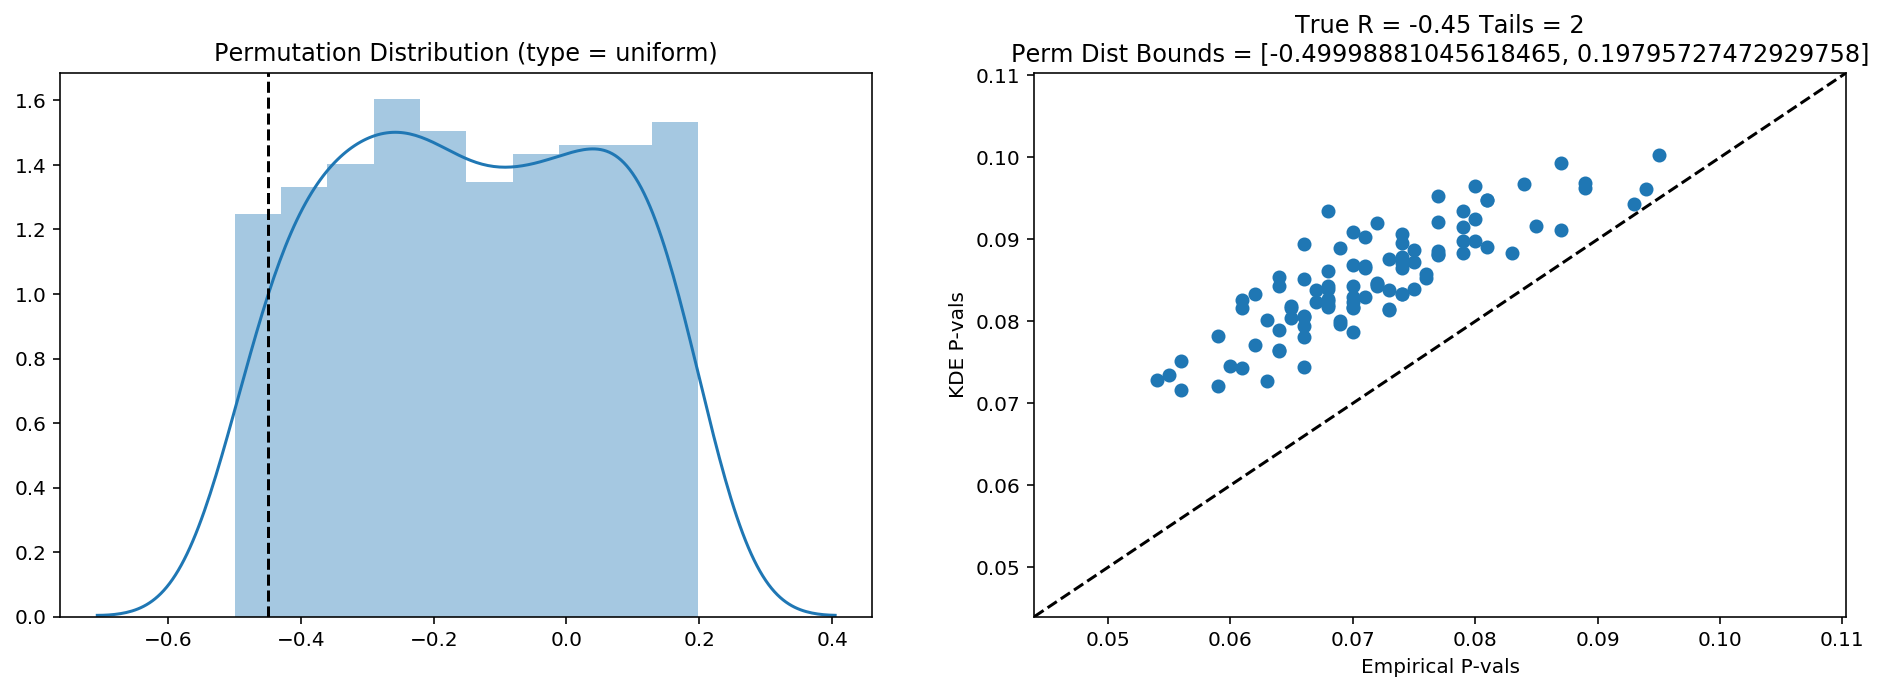

In [316]:
# Permuted distribution is a bit more conservative 
perms, kde_ps, empirical_ps, pfunc = kde_vs_empirical_sim(nsim=100, true_r=-.45, nperm=1000, tails=2, lower_r=-.5, upper_r=.2)

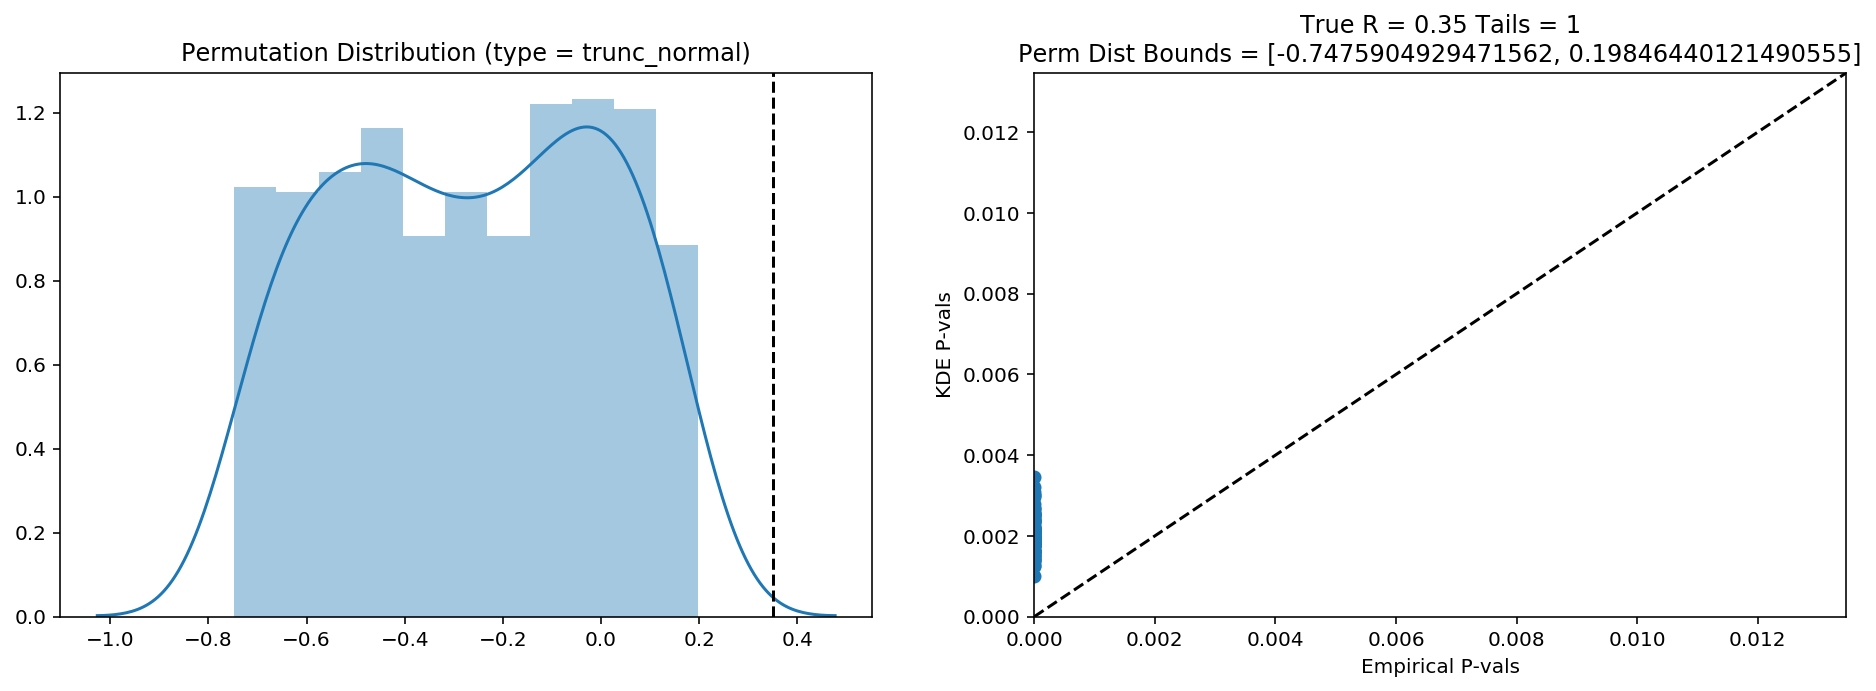

In [333]:
perms, kde_ps, empirical_ps, pfunc = kde_vs_empirical_sim(nsim=100, true_r=.35, nperm=1000, tails=1, lower_r=-.75, upper_r=.2,dist_type='trunc_normal')

In [317]:
# Create a bimodal distribution artificially
def bimodal(nperm):
    perms = np.random.uniform(-.6,.6001,nperm)
    perms[:200] = -.6
    perms[-200:] = .6
    return perms

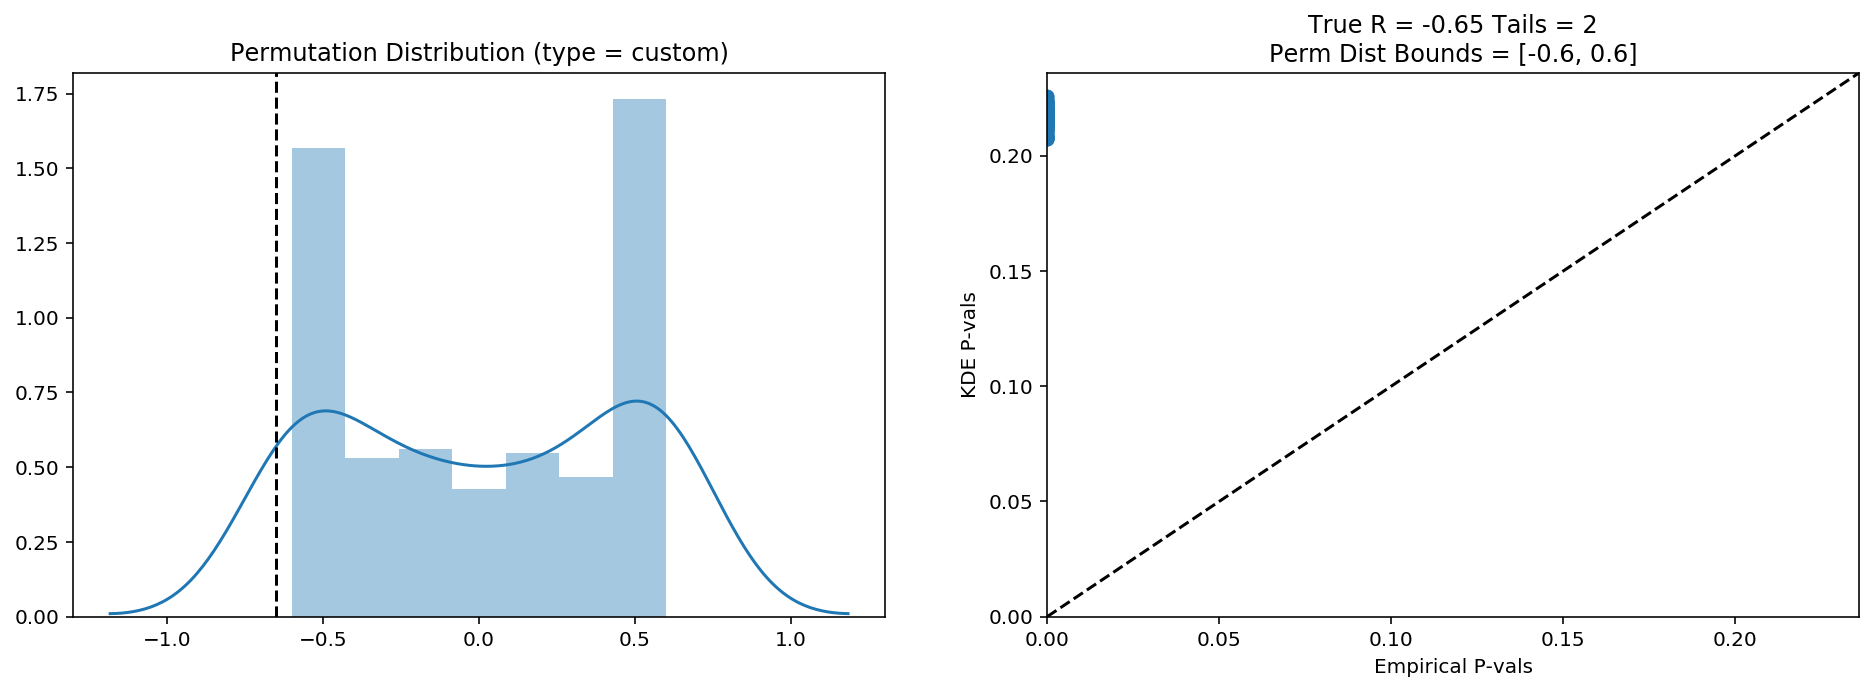

In [319]:
# Case where KDE pvalue is way more conservative than empirical
perms, kde_ps, empirical_ps, pfunc = kde_vs_empirical_sim(nsim=100,true_r=-.65,nperm=1000,tails=2,dist_type=bimodal)

Messing around with sklearn KDE. Not clear how to compute CDF easily using scipy integrate, which statsmodels does for your

In [195]:
from sklearn.neighbors import KernelDensity

In [246]:
grid = np.linspace(perms.min(),perms.max(),len(perms))
bw = (np.median(np.abs(perms - np.median(perms))) / 0.6745) * (4 / (3 * len(perms)))** (1 / 5)
out = np.exp(KernelDensity(bandwidth=bw).fit(perms[:,np.newaxis]).score_samples(grid[:,np.newaxis]))

(array([1.32670795, 1.05135347, 1.10141792, 1.32670795, 1.22657904,
        1.02632124, 1.52696575, 1.28915961, 1.26412738, 1.3767724 ]),
 array([-0.39991778, -0.32002077, -0.24012376, -0.16022675, -0.08032974,
        -0.00043273,  0.07946429,  0.1593613 ,  0.23925831,  0.31915532,
         0.39905233]),
 <a list of 10 Patch objects>)

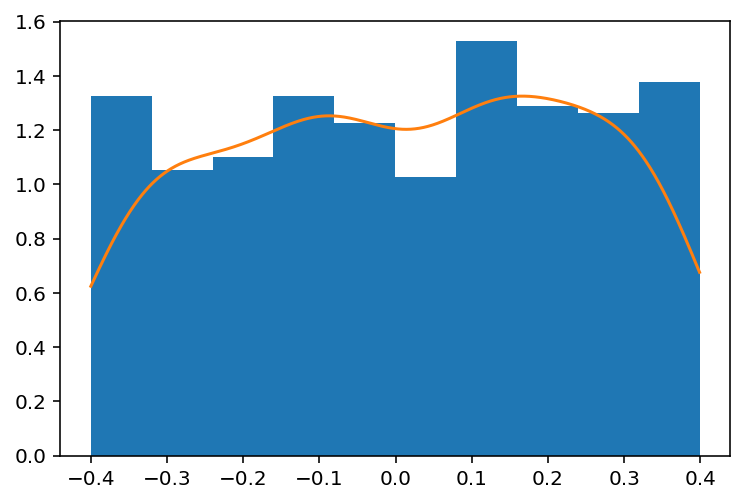

In [247]:
plt.hist(perms,density=True)
plt.plot(grid,out)

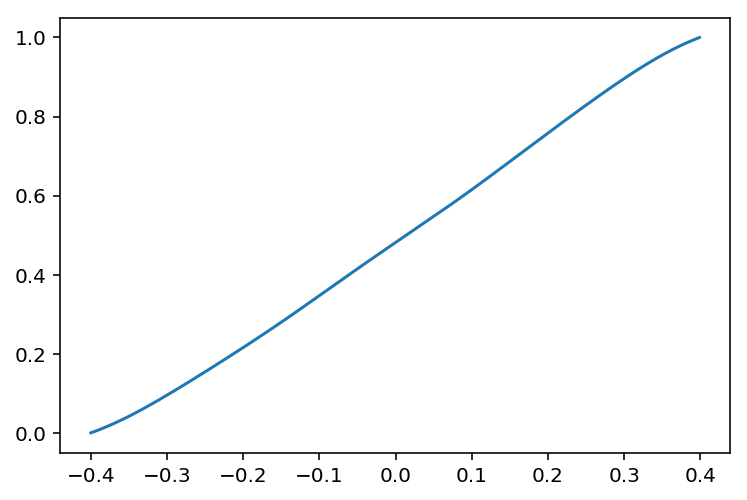

In [253]:
# Looks very diff than statsmodels CDF
plt.plot(grid,np.cumsum(out) / np.cumsum(out).max())

In [230]:
import statsmodels.api as sm
kde = sm.nonparametric.KDEUnivariate(perms)
kde.fit(gridsize=200,fft=False,bw=bw)
cdf = kde.cdf

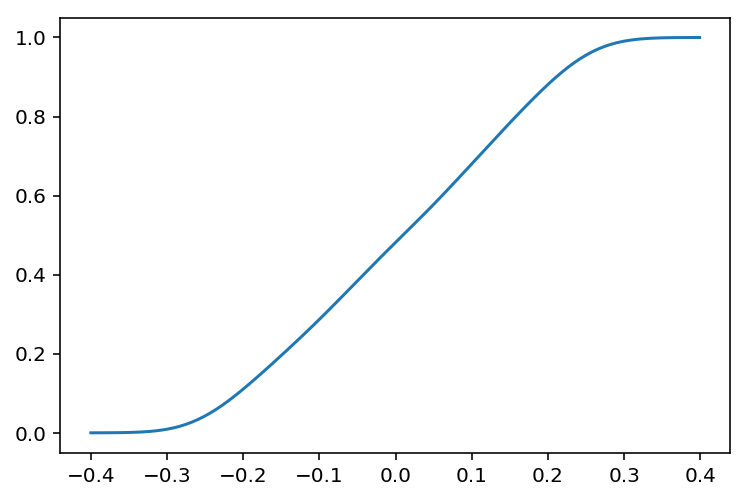

In [234]:
sm_grid = np.linspace(perms.min(),perms.max(),len(cdf))
plt.plot(sm_grid,cdf)

In [59]:
def matshow(mat,vals=False,figsize=(6,6)):
    '''Visualize a correlation matrix'''
    
    if vals:
        fmt = '.2f'
        annot=True
    else:
        fmt = None
        annot=False
    
    if not isinstance(mat,list):
        mat = [mat]
    
    w = 6 * len(mat)
    ncols = len(mat)
    f,ax = plt.subplots(ncols=ncols,figsize=(w,6))
    for i,m in enumerate(mat):
        _=sns.heatmap(m,square=True,vmin=-1,vmax=1,cmap='RdBu_r',fmt=fmt,annot=annot,ax=ax[i] if ncols > 1 else ax,cbar=False);
    return ax    
    

In [100]:
def create_homogenous_block_mat(n_samples,n_features,r_within,r_between,forcePSD=False):
    
    z = np.ones((n_features*2,n_features*2)) * r_within
    z[np.diag_indices(n_variables*2)] = 1
    z[n_variables:,:n_variables] = r_between
    z[:n_variables,n_variables:] = r_between
    
    if not isPSD(z):
        if forcePSD:
            return nearestPSD(z)
        else:
            raise ValueError("Matrix is not PSD")
    
    return z

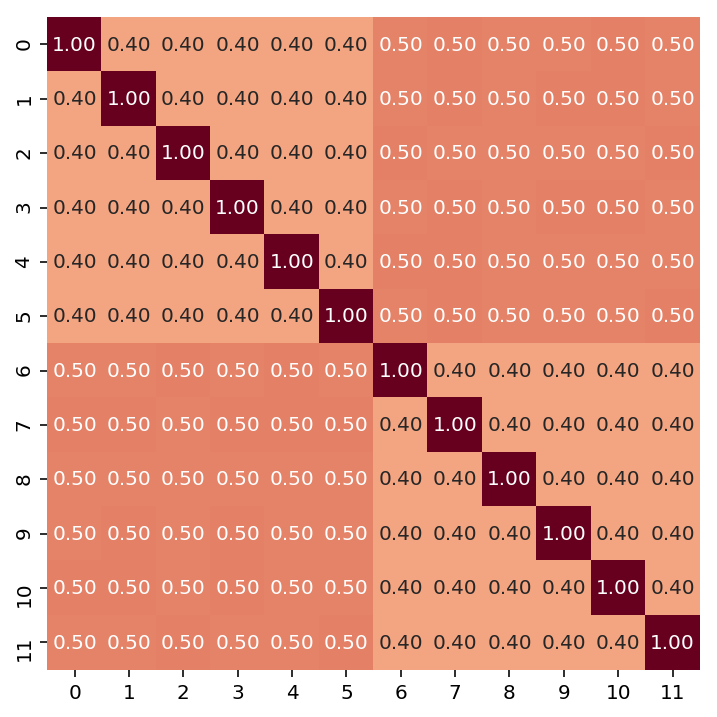

In [113]:
# Interesting example where there's limit on how much higher between r can be vs within r
# and still retain PSD
n_features = 6
r_within = .2
r_between = .7 
n_samples = 10
mat = create_homogenous_block_mat(n_samples, n_features, r_within, r_between, forcePSD=True)
matshow(mat,vals=True)